In [9]:
from nnsight import LanguageModel
import torch
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [18]:
torch.set_grad_enabled(False)

In [25]:
MODELS = ["meta-llama/Llama-3.2-1B"]

llm = LanguageModel(MODELS[0], device_map="auto", torch_dtype=torch.float32)

In [26]:
# Load the dataset
print(os.getcwd())
df = pd.read_csv(os.path.join(os.getcwd(), "sentences.csv"))

/Users/ivannaranjo/Documents/Helmholtz/experiments/hlmz-prep/logit_probabilities_plot_1


[(' Paris', ' Berlin')]
[[12366, 20437]]
[(' Everest', ' Kilimanjaro')]
[[87578, 38988]]
[(' Pacific', ' Atlantic')]
[[16867, 23179]]
[(' Mercury', ' Venus')]
[[44662, 50076]]
[(' Shakespeare', ' Dickens')]
[[42482, 93999]]
[(' Au', ' Ag')]
[[33150, 4701]]
[(' Russia', ' Canada')]
[[8524, 7008]]
[(' Armstrong', ' Moon')]
[[45966, 17781]]
[(' Yen', ' Won')]
[[123967, 43549]]
[(' bones', ' eyes')]
[[25896, 6548]]


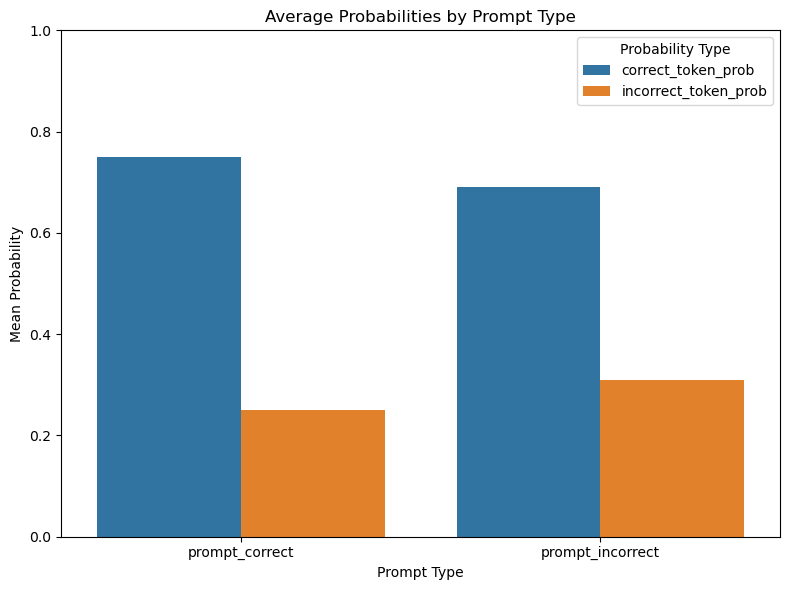

In [30]:
results = {"prompt_correct": {"correct_token_logit": [], "incorrect_token_logit": []}, "prompt_incorrect": {"correct_token_logit": [], "incorrect_token_logit": []}}
for i in range(len(df)):
    # Define the answers to these prompts, formatted as (correct, incorrect)
    answers = [
        (df.iloc[i]["answer_sentence1"], df.iloc[i]["answer_sentence2"]),
    ]

    answer_token_indices = [
        [llm.tokenizer(answers[i][j])["input_ids"][1] for j in range(2)]
        for i in range(len(answers))
    ]
    
    # nice print answers and answer token indices
    print(answers)
    print(answer_token_indices)

    s1 = df.iloc[i]["sentence1"]
    s2 = df.iloc[i]["sentence2"]
    last_sentence = df.iloc[i]["last_sentence"]
    prompt_correct = f"{s1}\n{s2}\nThis was the correct sentence:\n{last_sentence}"
    prompt_incorrect = f"{s1}\n{s2}\nThis was the false sentence:\n{last_sentence}"
    with llm.trace(prompt_correct): 
        output = llm.lm_head.output
        correct_token_logit = output[0, -1, answer_token_indices[0][0]]
        incorrect_token_logit = output[0, -1, answer_token_indices[0][1]]
        results["prompt_correct"]["correct_token_logit"].append(correct_token_logit.save())
        results["prompt_correct"]["incorrect_token_logit"].append(incorrect_token_logit.save())
    
    with llm.trace(prompt_incorrect):
        output = llm.lm_head.output
        correct_token_logit = output[0, -1, answer_token_indices[0][0]]
        incorrect_token_logit = output[0, -1, answer_token_indices[0][1]]
        results["prompt_incorrect"]["correct_token_logit"].append(correct_token_logit.save())
        results["prompt_incorrect"]["incorrect_token_logit"].append(incorrect_token_logit.save())

# Prepare data with average probabilities
data = []
for prompt_type in ["prompt_correct", "prompt_incorrect"]:
    correct_logits = [val.value.cpu() for val in results[prompt_type]["correct_token_logit"]]
    incorrect_logits = [val.value.cpu() for val in results[prompt_type]["incorrect_token_logit"]]
    
    # Compute probabilities for each sample
    probs_correct = []
    probs_incorrect = []
    for idx in range(len(correct_logits)):
        logits = torch.stack([correct_logits[idx], incorrect_logits[idx]])
        probs = torch.softmax(logits, dim=0).numpy()
        probs_correct.append(probs[0])  # Probability of correct token
        probs_incorrect.append(probs[1])  # Probability of incorrect token
    
    # Average probabilities across all samples
    mean_prob_correct = np.mean(probs_correct)
    mean_prob_incorrect = np.mean(probs_incorrect)
    
    # Add to data
    data.append({
        "Prompt": prompt_type,
        "Probability Type": "correct_token_prob",
        "Mean Probability": mean_prob_correct
    })
    data.append({
        "Prompt": prompt_type,
        "Probability Type": "incorrect_token_prob",
        "Mean Probability": mean_prob_incorrect
    })

df_plot = pd.DataFrame(data)

# Create the bar plot
plt.figure(figsize=(8, 6))
sns.barplot(
    x="Prompt",
    y="Mean Probability",
    hue="Probability Type",
    data=df_plot
)

plt.title('Average Probabilities by Prompt Type')
plt.xlabel('Prompt Type')
plt.ylabel('Mean Probability')
plt.legend(title='Probability Type')
plt.ylim(0, 1)  # Probabilities range from 0 to 1
plt.tight_layout()
plt.show()
